 ### Load the drive containing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Defining function to group less represented parties under the 'Others' category

In [3]:
def creating_category_others(data):
  # Using 0.99 quantile to categorize 'Others'
  threshold_value = data['count'].quantile(0.99)
  values_below_thresh = data['count'] < threshold_value
  data.loc[values_below_thresh,'Label'] = 'Others'
  return data

## Loading datasets

In [4]:
# Load dataset containing sport quotes
dataset = pd.read_csv('/content/drive/MyDrive/ADA/ada-sports-quotes/sport-quotes-2016.csv.bz2', compression='bz2', usecols=['speaker','qids','quoteID'])

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [5]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
dataset['qids'] = dataset['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(dataset['qids'])]

# Removing speakers without any known party (i.e. with 'party' == None)
politicians = speakers[~(speakers['party'].isna())]

## Computing the number of speakers per party from sport quotes

Only keeping the first qid for the 'party' feature. It is known, that it is not correct because we should select the party in which the speaker was at the time of the quote. This will be solved for Milestone 3, as this requires new speaker_features dataset to obtain this information. 

In [6]:
# Only keeping the first qid in the 'party' feature (with str.get(0))
# Counts the occurences of each party and adding the corresponding party label by merging qid_labels
party_speaker_counts_label = pd.DataFrame(pd.value_counts(politicians['party'].str.get(0))).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_speaker_counts_label = creating_category_others(party_speaker_counts_label)

## Computing the number of quotes per party from sport quotes

In [7]:
# Selecting quotes from a speaker with a party and merging the speaker_attributes dataset
dataset_politicians_attributes = dataset[dataset['qids'].isin(politicians['id'])].merge(speaker_attributes, left_on='qids', right_on='id')
# Only keeping the first qid in the 'party' feature (with str.get(0))
dataset_politicians_attributes['party'] = dataset_politicians_attributes['party'].str.get(0)

# Counts the occurences of each party and add the corresponding party label 
party_quotes_counts_label = pd.DataFrame(pd.value_counts(dataset_politicians_attributes['party'])).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_quotes_counts_label = creating_category_others(party_quotes_counts_label)

## Plots : pie plots and bar plots

Speaker's party distribution

Text(0.6, 0.92, "Speaker's party distribution of sport quotes for year 2016")

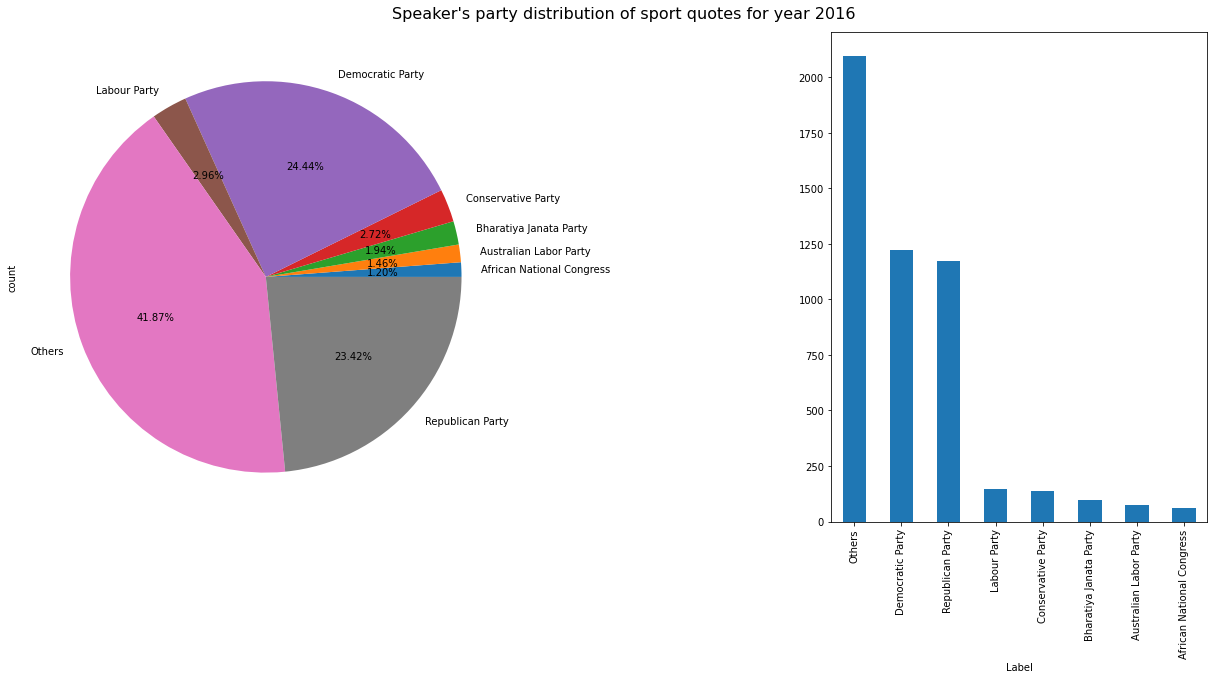

In [8]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_speaker_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0])
party_speaker_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1])

plt.subplots_adjust(wspace=0)
fig.suptitle('Speaker\'s party distribution of sport quotes for year 2016', fontsize=16, x=0.6, y=0.92)

Quote's party distribution

Text(0.6, 0.92, "Quote's party distribution of sport quotes for year 2016")

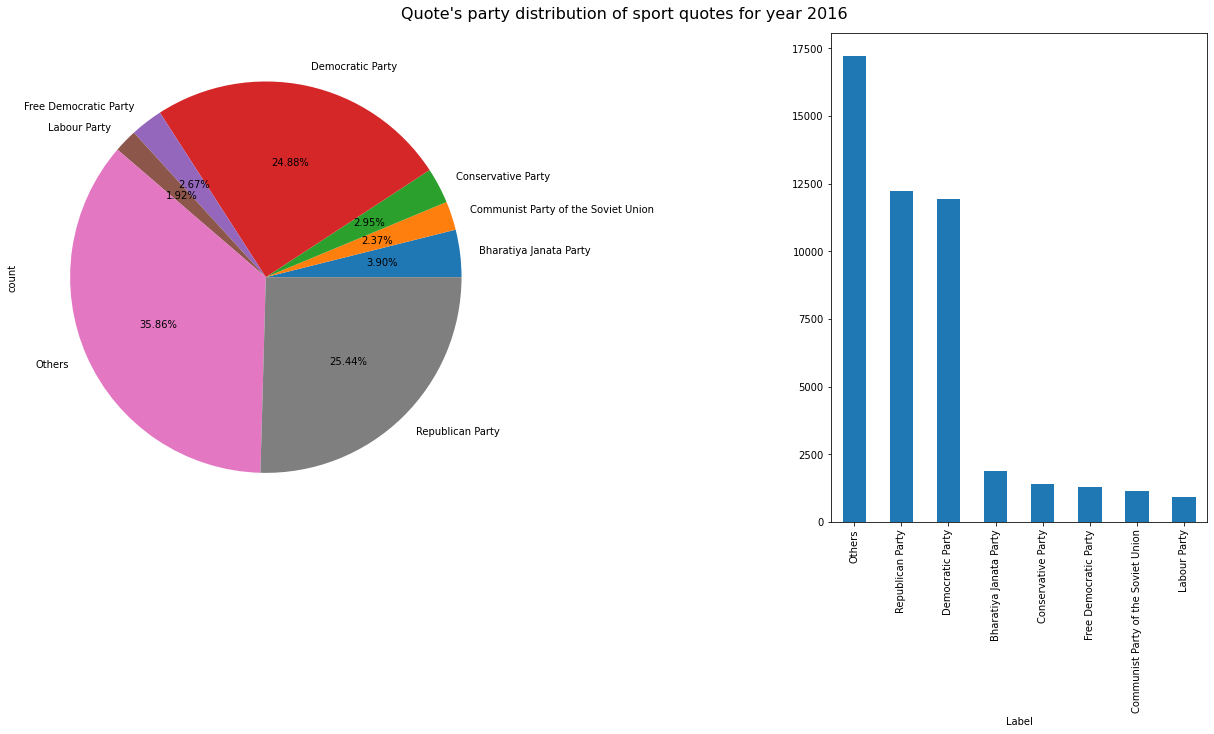

In [9]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_quotes_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0])
party_quotes_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1])

plt.subplots_adjust(wspace=0)
fig.suptitle('Quote\'s party distribution of sport quotes for year 2016', fontsize=16, x=0.6, y=0.92)

## Data description and overview

Lengths of DataFrame (i.e. number of sample)

In [10]:
print('Number of sport quotes: {q_sport}\nNumber of political quotes: {q_pol}\nNumber of speakers: {spea}\nNumber of politicians (i.e. speakers with political party): {pol}\nNumber of different parties: {part}'\
      .format(q_sport=dataset.shape[0], spea=speakers.shape[0], pol=politicians.shape[0], part=party_speaker_counts_label.shape[0], q_pol=dataset_politicians_attributes.shape[0]))

Number of sport quotes: 2286930
Number of political quotes: 48014
Number of speakers: 65574
Number of politicians (i.e. speakers with political party): 5008
Number of different parties: 619


In [11]:
dataset.sample(5)

,quoteID,speaker,qids
1268214,2016-06-30-028589,Barry Trotz,Q608839
728704,2016-04-28-011148,Darin Erstad,Q861442
206740,2016-05-09-046787,None,
1764660,2016-09-30-028740,None,
477110,2016-09-25-021465,Jimmye Laycock,Q6201668


In [12]:
speakers.sample(5)

,nationality,party,id
3414162,[Q219],None,Q446255
1336048,None,None,Q7612092
6990904,[Q30],None,Q7366416
3405586,[Q1008],None,Q180462
2440215,"[Q145, Q25]",None,Q6275805


In [13]:
politicians.sample(5)

,nationality,party,id
1272453,"[Q408, Q664]",[Q781392],Q5145333
2267323,[Q30],[Q29552],Q37175
8351879,None,[Q29468],Q29453398
4571937,[Q30],[Q29468],Q1345645
2453759,[Q30],[Q29552],Q6962875


In [14]:
party_speaker_counts_label.head(5)

,count,Label,Description
QID,,,
Q29552,1224,Democratic Party,political party in the United States
Q29468,1173,Republican Party,major political party in the United States
Q9630,148,Labour Party,political party in the United Kingdom
Q9626,136,Conservative Party,political party in the United Kingdom
Q10230,97,Bharatiya Janata Party,major political party in India


In [15]:
dataset_politicians_attributes.sample(5)

,quoteID,speaker,qids,nationality,party,id
9383,2016-07-24-066207,Ramalinga Reddy,Q16735074,[Q668],Q10225,Q16735074
4038,2016-02-14-058896,Adam Silver,Q4679786,[Q30],Q29552,Q4679786
39510,2016-08-22-002608,Bernardo Rezende,Q716465,[Q155],Q1322897,Q716465
907,2016-08-04-126282,President Barack Obama,Q76,[Q30],Q29552,Q76
20241,2016-09-08-023845,bill de blasio,Q4911497,[Q30],Q29552,Q4911497


In [16]:
party_quotes_counts_label.head(5)

,count,Label,Description
QID,,,
Q29468,12214,Republican Party,major political party in the United States
Q29552,11946,Democratic Party,political party in the United States
Q10230,1874,Bharatiya Janata Party,major political party in India
Q9626,1415,Conservative Party,political party in the United Kingdom
Q13124,1283,Free Democratic Party,political party in Germany
